# SIR Model Parameter Exploration Notebook

This notebook explores the behavior of the basic SIR (Susceptible-Infection-Recovered) compartmental model under different parameter regimes. 

### Model Overview

The SIR model describes disease transmission through three differential equations:
 
 - dS/dt = -β·S·I/N
 - dI/dt = β·S·I/N - γ·I
 - dR/dt = γ·I
 
### Key Parameters:
 - **β (beta)**: transmission rate
 - **γ (gamma)**: recovery rate (1/γ = mean infectious period)
 - **R₀ = β/γ**: basic reproduction number
 
 ### Critical Threshold:
 - R₀ > 1: Epidemic occurs
 - R₀ < 1: Disease dies out

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from epimodels.sir_model import SIRModel, compute_epidemic_metrics
from epimodels.utils.sir_figures import (plot_simulation, plot_phase_portrait, 
                         plot_multiple_phase_portraits, plot_infected_comparison,
                         plot_parameter_grid, plot_final_size_relation)

# set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic SIR Simulation 

In [54]:
# Population paramters
N = 1000       # total population
I0 = 1          # initial infected
R0_init = 0     # initial recovered
S0 = N - I0 - R0_init   # initial susceptible

# Disease paramters (assuming known)
beta = 0.5      # transmission rate
gamma = 0.1     # recovery rate (mean infectious period = 10 days)

# Time vector
t = np.linspace(0, 160, 1000)

Basic Reproduction Number (R₀): 5.00


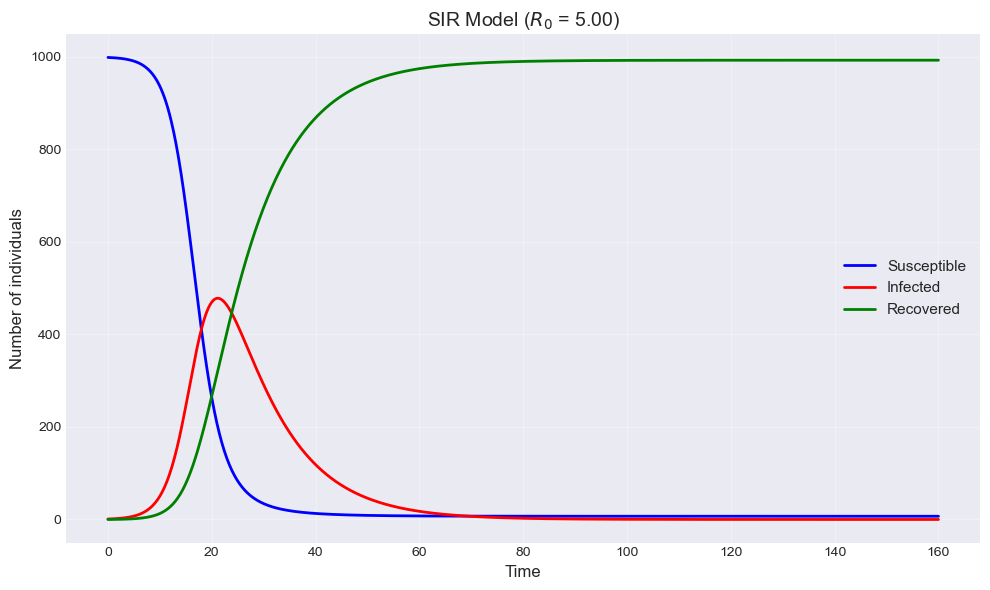


Epidemic Metrics:
  Peak infected: 478.3 individuals
  Peak time: 21.1 days
  Attack rate: 99.3%
  Epidemic duration: 73.7 days


In [55]:
# Create and run the model
model = SIRModel(beta=beta, gamma=gamma, N=N)
print(f"Basic Reproduction Number (R\u2080): {model.R0:.2f}")

S, I, R = model.simulate(S0, I0, R0_init, t)

# plot results
plot_simulation(t, S, I, R, R0=model.R0)

# Compute metrics
metrics = compute_epidemic_metrics(t, I, R)
print("\nEpidemic Metrics:")
print(f"  Peak infected: {metrics['peak_infected']:.1f} individuals")
print(f"  Peak time: {metrics['peak_time']:.1f} days")
print(f"  Attack rate: {metrics['attack_rate']/N*100:.1f}%")
print(f"  Epidemic duration: {metrics['epidemic_duration']:.1f} days")

## Impact of Transmission Rate ($\beta$)

Exploring how transmission rate affects epidemic dynamics

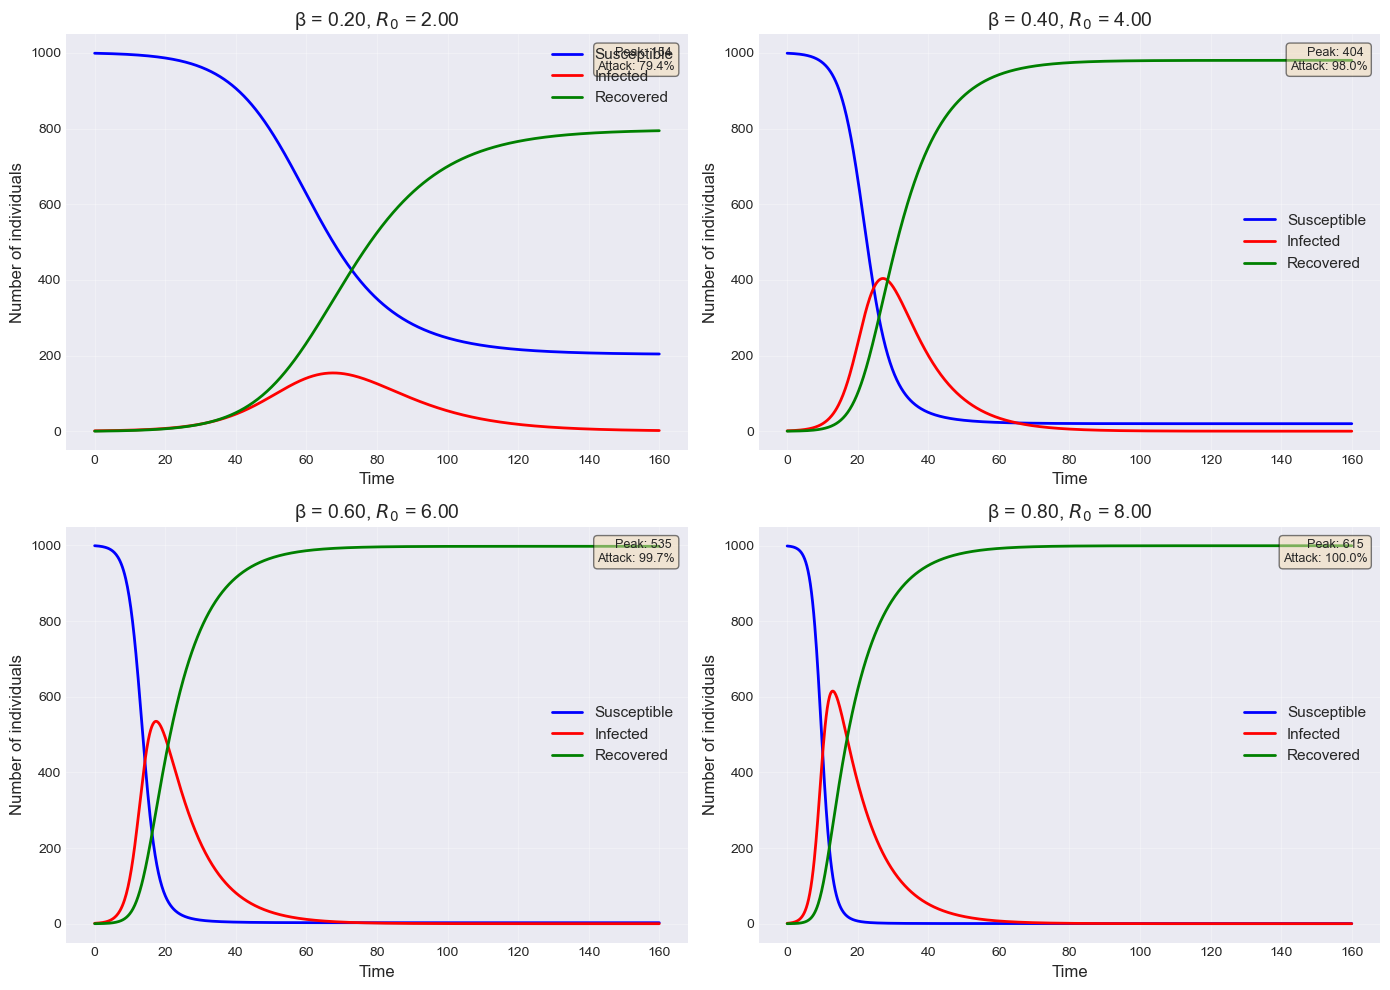

In [56]:
beta_values = [0.2, 0.4, 0.6, 0.8]
gamma = 0.1 

simulations = []
for beta in beta_values:
    model = SIRModel(beta=beta, gamma=gamma, N=N)
    S, I, R = model.simulate(S0, I0, R0_init, t)
    metrics = compute_epidemic_metrics(t, I, R)
    simulations.append((S, I, R, beta, model.R0, metrics))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (S, I, R, beta_val, R0_val, metrics) in enumerate(simulations):
    ax = axes[i]
    plot_simulation(t, S, I, R, R0=None, ax=ax, show=False, title = f'\u03B2 = {beta_val:.2f}, $R_0$ = {R0_val:.2f}')
    text = (f"Peak: {metrics['peak_infected']:.0f} \n" 
            f"Attack: {metrics['attack_rate']/N*100:.1f}%")
    ax.text(0.98, 0.97, text, 
            transform=ax.transAxes, 
            verticalalignment="top", 
            horizontalalignment="right", 
            bbox=dict(boxstyle="round", 
                      facecolor="wheat", alpha=0.5), 
                      fontsize=9)
    
plt.tight_layout()
plt.show()


## Impact of Recovery Rate ($\gamma$) 

Exploring how infectious period (1/$\gamma$) affects epidemic dynamics

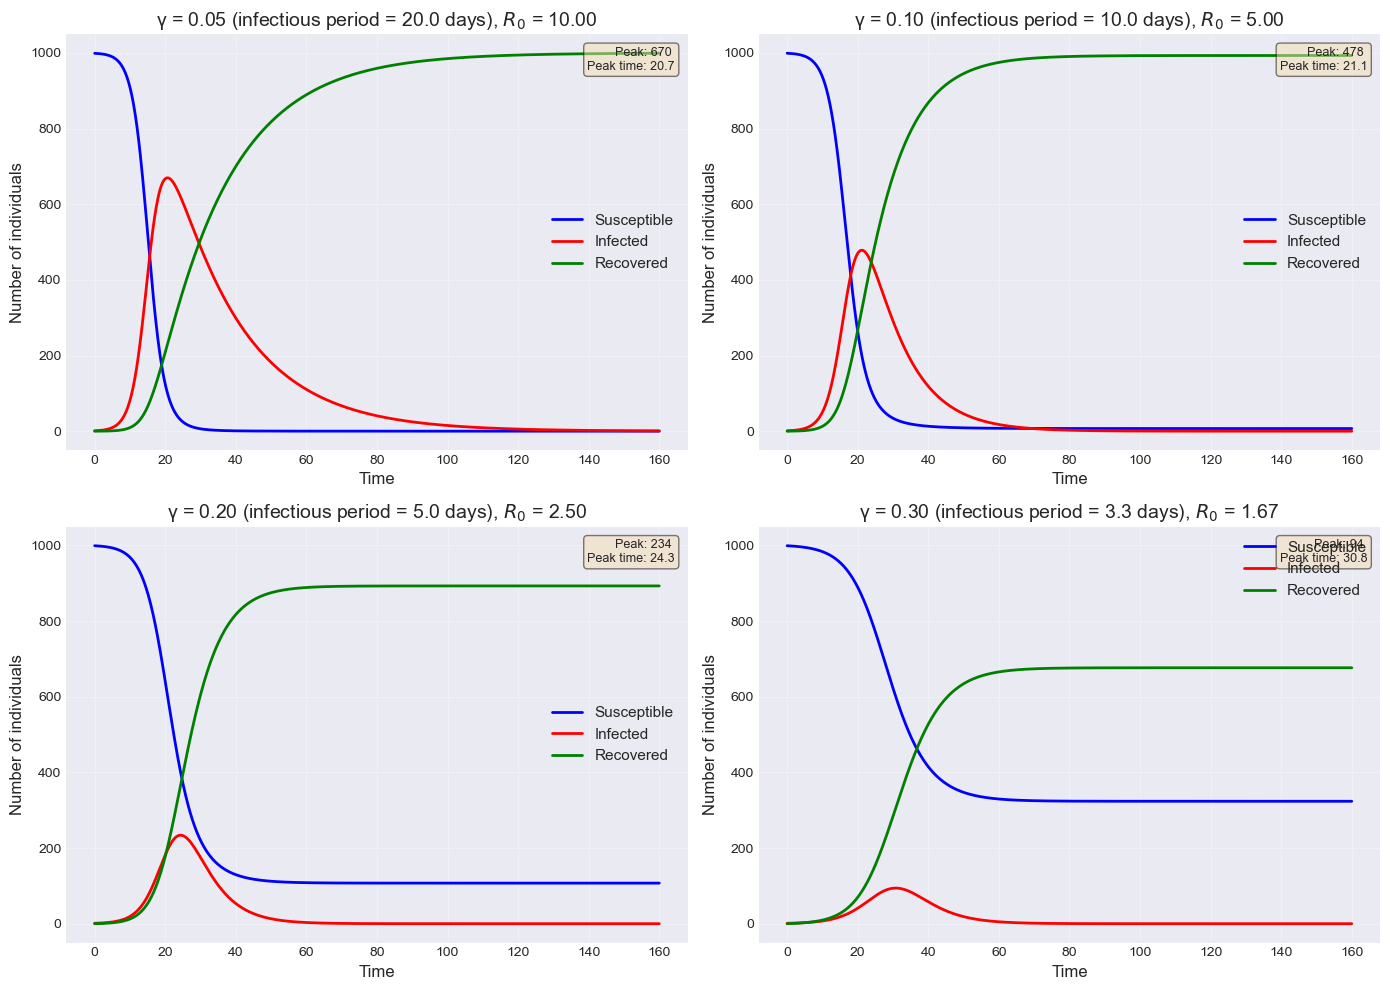

In [57]:
beta = 0.5
gamma_values = [0.05, 0.1, 0.2, 0.3]

simulations = []

for gamma in gamma_values:
    model = SIRModel(beta=beta, gamma=gamma, N=N)
    S, I, R = model.simulate(S0, I0, R0_init, t)
    metrics = compute_epidemic_metrics(t, I, R)
    simulations.append((S, I, R, gamma, model.R0, metrics))

# create a custom grid to show infectious period in title
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (S, I, R, gamma_val, R0_val, metrics) in enumerate(simulations):
    ax = axes[i]
    plot_simulation(t, S, I, R, R0=None, ax=ax, show=False, title = f'\u03B3 = {gamma_val:.2f} (infectious period = {1/gamma_val:.1f} days), $R_0$ = {R0_val:.2f}')
    text = (f"Peak: {metrics['peak_infected']:.0f} \n" 
            f"Peak time: {metrics['peak_time']:.1f}")
    ax.text(0.98, 0.97, text, 
            transform=ax.transAxes, 
            verticalalignment="top", 
            horizontalalignment="right", 
            bbox=dict(boxstyle="round", 
                      facecolor="wheat", alpha=0.5), 
                      fontsize=9)
    
plt.tight_layout()
plt.show()

## R<sub>0</sub> Threshold Analysis

Demonstrating the critical threshold at R<sub>0</sub> = 1

c:\Users\vscerra\Desktop\DataScienceProjects\disease_modeling_project\src\epimodels\utils\sir_figures.py:237: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.show()
c:\Users\vscerra\.conda\envs\my-env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


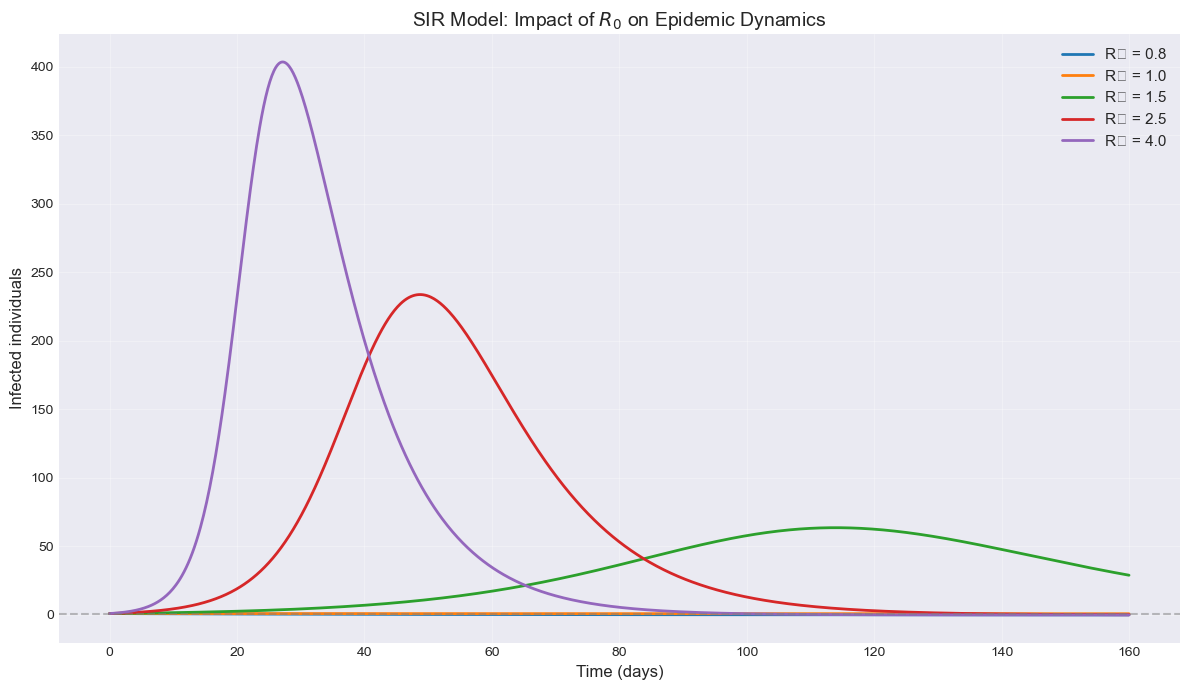

Key observation: When R₀ < 1, the disease cannot establish an epidemic


In [58]:
gamma = 0.1
R0_values = [0.8, 1.0, 1.5, 2.5, 4.0]

infected_series = []
for R0_target in R0_values:
    beta = R0_target * gamma 
    model = SIRModel(beta=beta, gamma=gamma, N=N)
    S, I, R = model.simulate(S0, I0, R0_init, t)
    infected_series.append((I, f"R\u2080 = {R0_target:.1f}"))

plot_infected_comparison(t, infected_series, title='SIR Model: Impact of $R_0$ on Epidemic Dynamics',
                         show_threshold=True)

print("Key observation: When R\u2080 < 1, the disease cannot establish an epidemic")

## Phase Portrait Analysis

Visualizing dynamics in the S-I plane reveals the trajectory structure

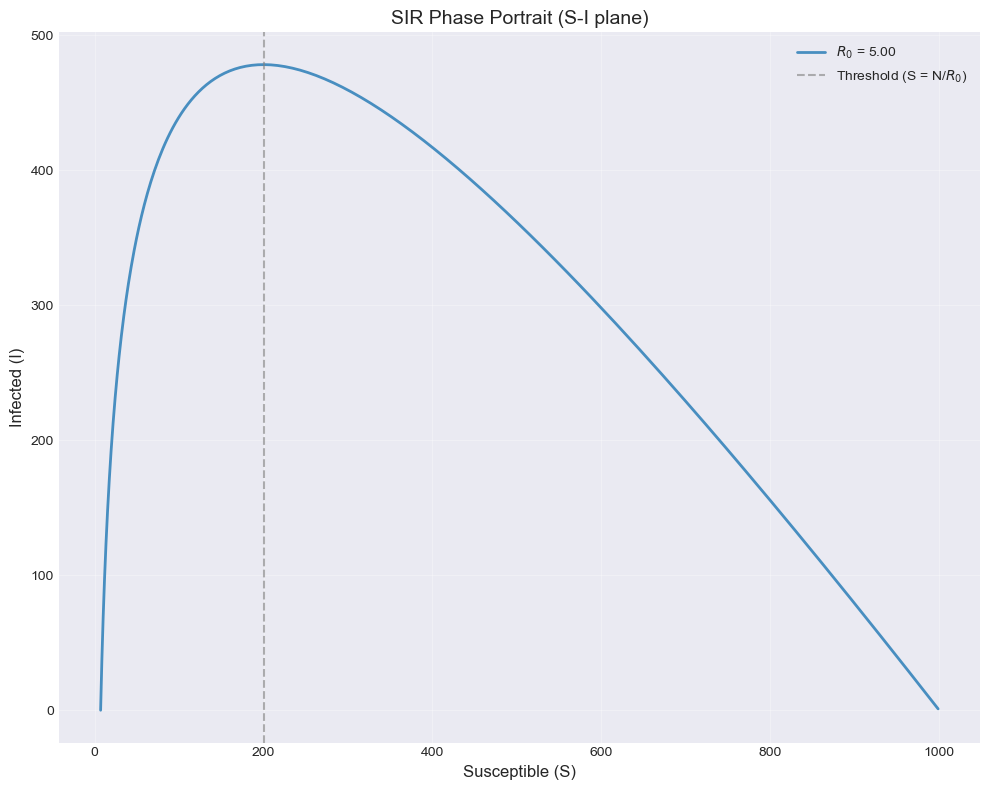


Note: The epidemic threshold S = N/R₀ = 200.0
When S < N/R₀, infections decrease (moving left in phase space)
When S > N/R₀, infections increase (moving right in phase space)


In [59]:
# single phase portrait
beta = 0.5
gamma = 0.1 
model = SIRModel(beta=beta, gamma=gamma, N=N)
S, I, R = model.simulate(S0, I0, R0_init, t)

plot_phase_portrait(S, I, R0=model.R0, N=N)
print(f"\nNote: The epidemic threshold S = N/R₀ = {N/model.R0:.1f}")
print("When S < N/R₀, infections decrease (moving left in phase space)")
print("When S > N/R₀, infections increase (moving right in phase space)")

## Multiple Phase Portraits for Different R<sub>0</sub> 

Comparing trajectories for different reproduction numbers

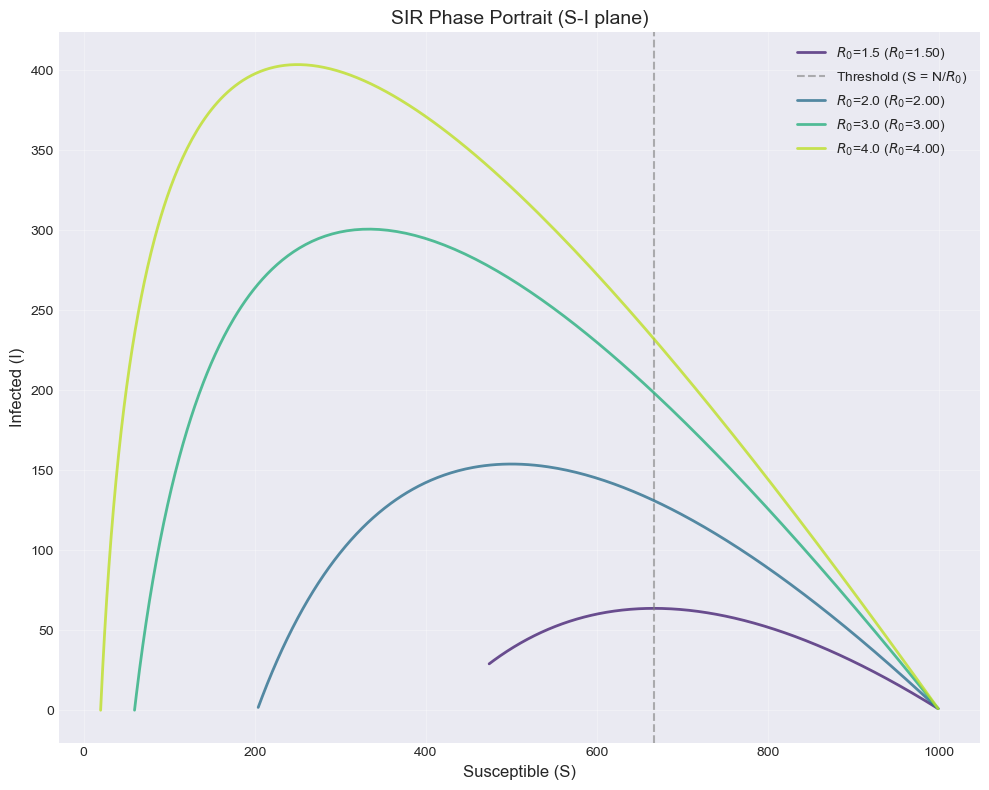

In [66]:
gamma = 0.1
R0_values_phase = [1.5, 2.0, 3.0, 4.0]

phase_simulations = []
for R0_target in R0_values_phase:
    beta = R0_target * gamma
    model = SIRModel(beta=beta, gamma=gamma, N=N)
    S, I, R = model.simulate(S0, I0, R0_init, t)
    phase_simulations.append((S, I, R0_target, f'$R_0$={R0_target:.1f}'))

plot_multiple_phase_portraits(phase_simulations, N=N);


## Initial Conditions Sensitivity

How does the initial number of infected individuals affect disease progression dynamics?

C:\Users\vscerra\AppData\Local\Temp\ipykernel_25300\1281895772.py:36: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()


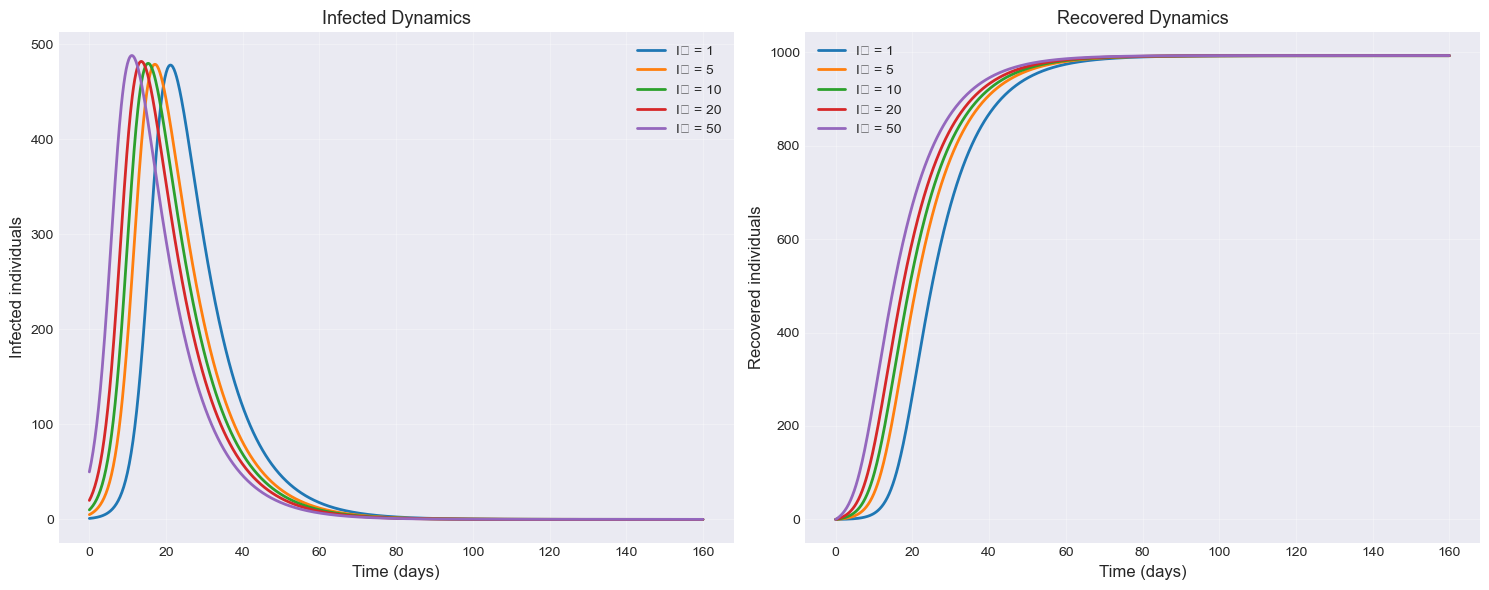

Note: Initial conditions affect timing but not final epidemic size!


In [61]:
beta = 0.5
gamma = 0.1
model = SIRModel(beta=beta, gamma=gamma, N=N)

I0_values = [1, 5, 10, 20, 50]

infected_series = []
recovered_series = []

for I0_var in I0_values:
    S0_var = N - I0_var
    S, I, R = model.simulate(S0_var, I0_var, 0, t)
    infected_series.append((I, f"I\u2080 = {I0_var}"))
    recovered_series.append((R, f"I\u2080 = {I0_var}"))

# plot infected dynamics
# Plot infected dynamics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for I, label in infected_series:
    ax1.plot(t, I, linewidth=2, label=label)
ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel('Infected individuals', fontsize=12)
ax1.set_title('Infected Dynamics', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

for R, label in recovered_series:
    ax2.plot(t, R, linewidth=2, label=label)
ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel('Recovered individuals', fontsize=12)
ax2.set_title('Recovered Dynamics', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Initial conditions affect timing but not final epidemic size!")

## Final Epidemic Size vs. R<sub>0</sub>

Exploring the relationship between R<sub>0</sub> and attack rate

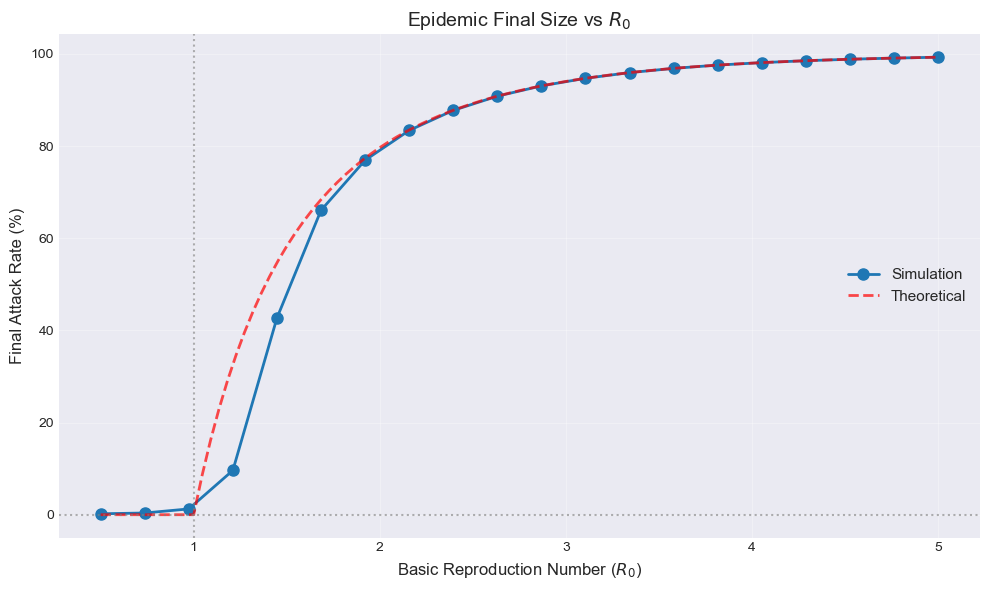


The theoretical final size relation is implicit:
R_∞/N = 1 - exp(-R₀ · R_∞/N)
where R_∞ is the final number of recovered individuals


In [65]:
gamma = 0.1
R0_range = np.linspace(0.5, 5, 20)

attack_rates_final = []
for R0_target in R0_range:
    beta = R0_target * gamma
    model = SIRModel(beta=beta, gamma=gamma, N=N)
    S, I, R = model.simulate(S0, I0, R0_init, t)
    attack_rates_final.append(R[-1]) # final recovered for each sim

plot_final_size_relation(R0_range, np.array(attack_rates_final), N, theoretical=True)

print("\nThe theoretical final size relation is implicit:")
print("R_∞/N = 1 - exp(-R₀ · R_∞/N)")
print("where R_∞ is the final number of recovered individuals")